### This notebook consists of an analysis performed on the PPO-MLP DRL agent using methodology from "5.Experiments and Comparison" chapter presented in the paper "Towards understanding of Deep Reinforcement Learning Agents used in Cloud Resource Management" 

In [1]:
import torch
import numpy as np
import sys
import os
from stable_baselines3 import PPO
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.getcwd()+'/../analysis/src/')
%load_ext autoreload
%autoreload 2

from attribute import *
from plot import *
from ppo_policy import *
from utils import *
from ppo_policy import PPOPolicy

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model and array of observations for analysis

In [2]:
BASE_PATH2 = '../initial_model'

model = PPO.load(f'{BASE_PATH2}/best_models/ppo_MlpPolicy')

X = np.load(f'{BASE_PATH2}/observations/observations_ppo_MlpPolicy_1.npy')
X = torch.Tensor(X)
X.shape
print(f'Shape of the observation array is: {X.numpy().shape}')

Shape of the observation array is: (2410, 1, 7)


## Make predictions

In [3]:
predictions = np.squeeze(np.load(f'{BASE_PATH2}/actions/actions_ppo_MlpPolicy.npy'), axis=1)

## Histogram of the actions

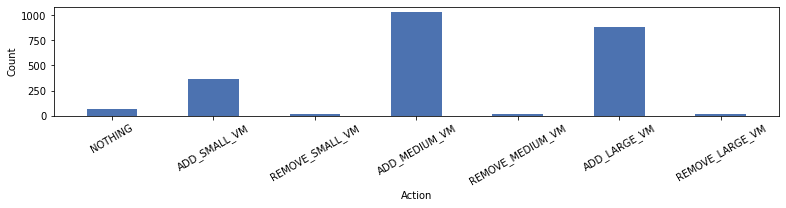

In [4]:
plot_action_histogram(predictions)

## 5.2 Sample run - agent response (VM allocation) to the workload changes

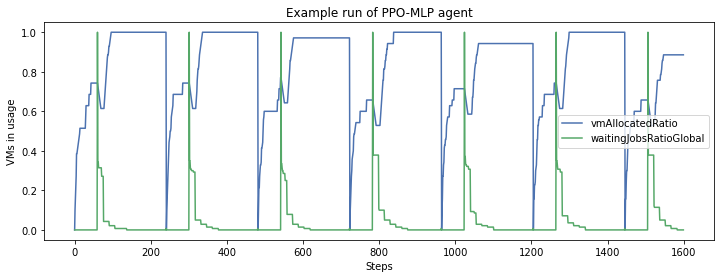

In [5]:
observations =  np.load(f'{BASE_PATH2}/ppo/MlpPolicy/observations.npy')
observations = np.squeeze(observations, axis=1)
df = pd.DataFrame(observations, columns = Utils.FEATURE_NAMES)

N_steps = 1600
columns = [
    "vmAllocatedRatio",
    "waitingJobsRatioGlobal"
    ]

fig = plt.figure(figsize=(12, 4))
plt.xlabel("Steps")
plt.ylabel("VMs in usage")
plt.plot(df[columns][:N_steps])
plt.title(f'Example run of PPO-MLP agent')
plt.legend(columns, loc='center right')
plt.show()

## Extract underlying DNN from the PPO-MLP agent

In [7]:
ppo_net = PPOPolicy(model.observation_space, model.action_space, model.lr_schedule, model)

## 5.4 Policy summarization (mean attributions over the example observations)

In [8]:
N = 2000
idxs = np.random.choice(np.arange(X.shape[0]), size=N)
X_sample = X[idxs]
predictions_sample = predictions[idxs]

main_ig_attributor = IGAttributor(net=ppo_net,
                                  policy='mlp',
                                  agent='ppo',
                                  data=X_sample,
                                  predictions=predictions_sample)

mean_attributions_per_action = main_ig_attributor.get_mean_attributions()

### Absolute Mean Attributions - Feature Importance

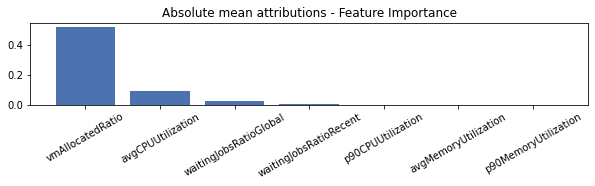

In [9]:
plot_mean_attributions(mean_attributions=mean_attributions_per_action[0], abs=True)

### Mean attributions

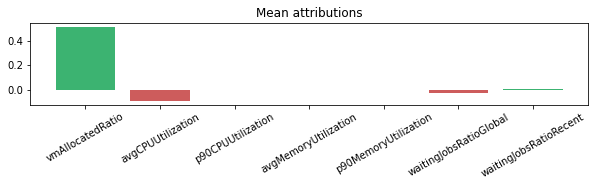

In [10]:
plot_mean_attributions(mean_attributions=mean_attributions_per_action[0])

## 5.5 Evolution of policies during training (watching the process of policy formation)

In [11]:
model_policy = '/ppo/MlpPolicy/best_model_'

# Paths to the agents saved at different stages of the training process
models = [
    PPO.load(f'{BASE_PATH}{model_policy}0_1.zip'),
    PPO.load(f'{BASE_PATH}{model_policy}1_25000.zip'),
    PPO.load(f'{BASE_PATH}{model_policy}2_50000.zip'),
    PPO.load(f'{BASE_PATH}{model_policy}3_75000.zip'),
    PPO.load(f'{BASE_PATH}{model_policy}4_100000.zip'),
]
n_steps = [1, 25000, 50000, 75000, 100000]

# Load observations
X = np.load(f'{BASE_PATH2}/observations/observations_ppo_MlpPolicy_1.npy')
X = torch.Tensor(X)

predictions = []
for model in models:
    predictions_model = []
    for _ in X:
        predictions_model.append(model.predict(X[0])[0][0])
    predictions_model = np.array(predictions_model)
    predictions.append(predictions_model)

# Extract underlying DNNs from agents
nets = [PPOPolicy(model.observation_space, model.action_space, model.lr_schedule, model) for model in models]



# Calculate attributions for model from each stage
N = 600
idxs = np.random.choice(np.arange(X.shape[0]), size=N)
X_sample = X[idxs]

ig_attributors = []
for i, net in enumerate(nets):
    predictions_sample = predictions[i][idxs]

    ig_attributor = IGAttributor(net=net,
                                policy='mlp',
                                agent='ppo',
                                data=X_sample,
                                predictions=predictions_sample)

    ig_attributors.append(ig_attributor)


### Evolution of PPO-MLP policy Feature Importance

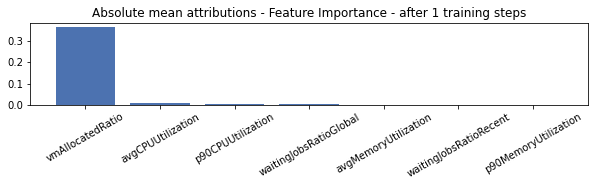

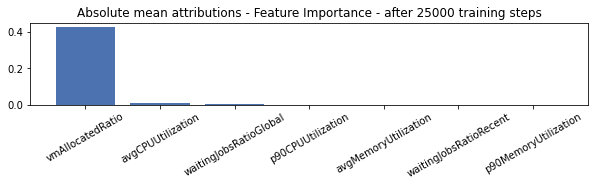

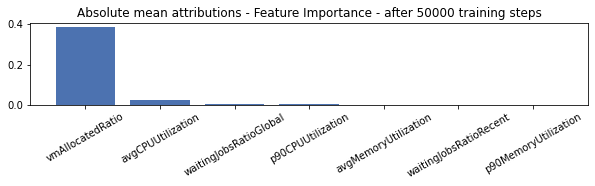

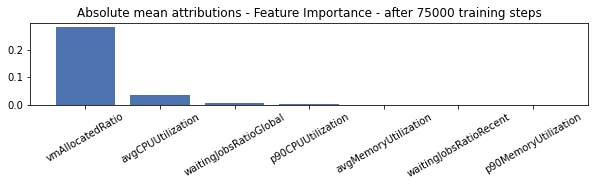

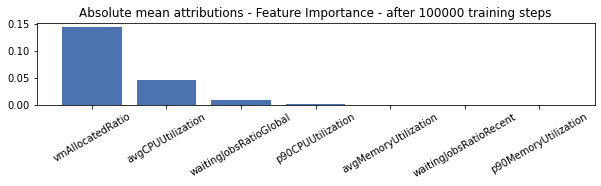

In [12]:
for ig_attributor, i in zip(ig_attributors, n_steps):
    mean_attributions_per_action = ig_attributor.get_mean_attributions()
    plot_mean_attributions(mean_attributions=mean_attributions_per_action[0], abs=True, title_postfix=f' - after {i} training steps')

### Evolution of PPO-MLP policy Mean Attributions

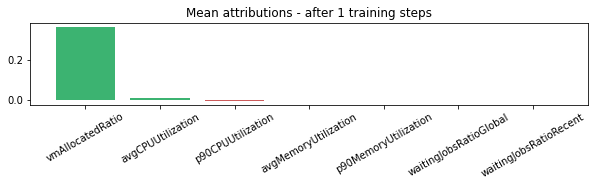

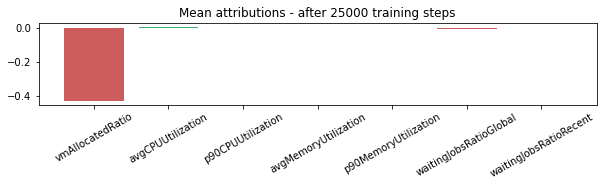

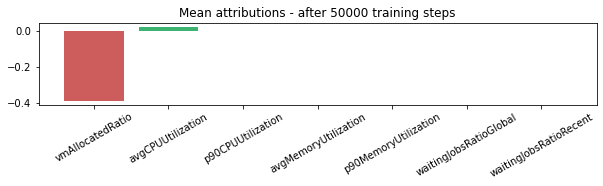

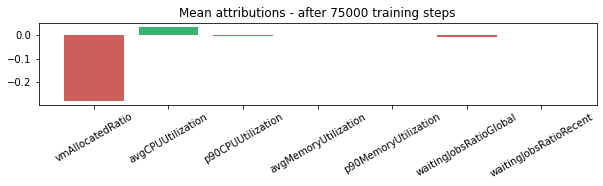

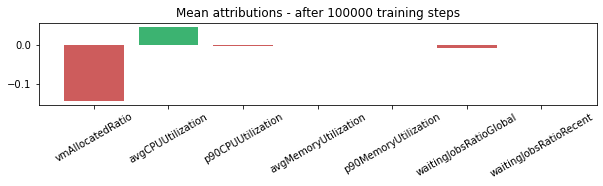

In [13]:
for ig_attributor, i in zip(ig_attributors, n_steps):
    mean_attributions_per_action = ig_attributor.get_mean_attributions()
    plot_mean_attributions(mean_attributions=mean_attributions_per_action[0], title_postfix=f' - after {i} training steps')

### Evolution of PPO-MLP reposnse and attributions for the same environment state

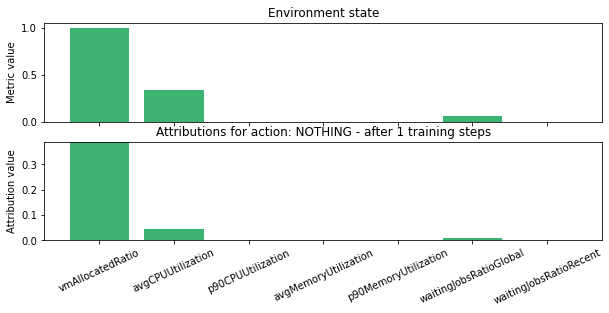

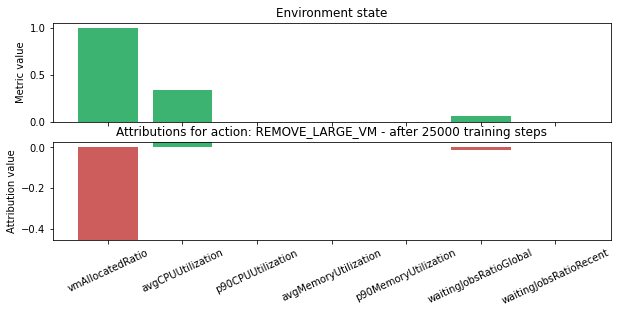

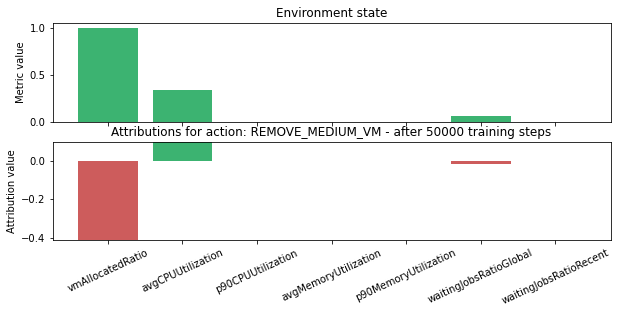

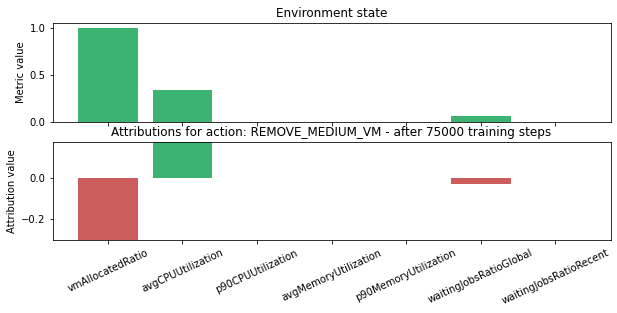

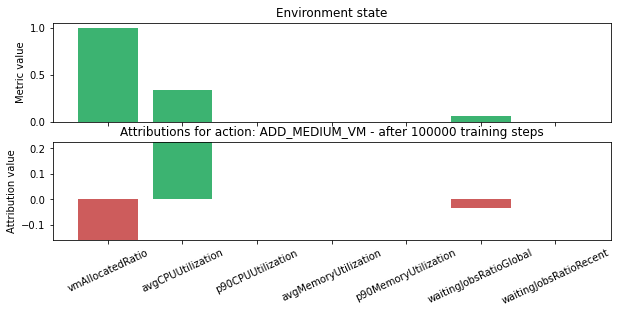

In [14]:
for ig_attributor, i in zip(ig_attributors, n_steps):
    ig_attributor.explain_example(350, print_q_values=False, title_postfix=f' - after {i} training steps')

## 5.6 Debugging (examining agent predictions for example observations)

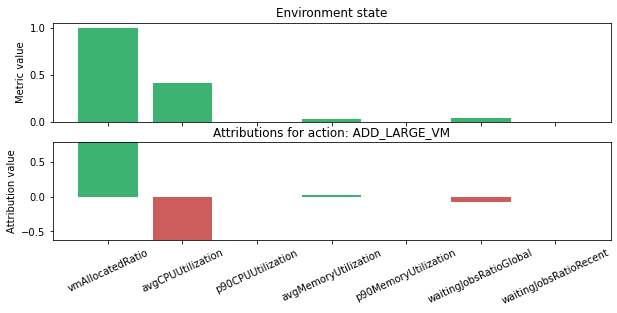

In [23]:
main_ig_attributor.explain_example(idx=424)

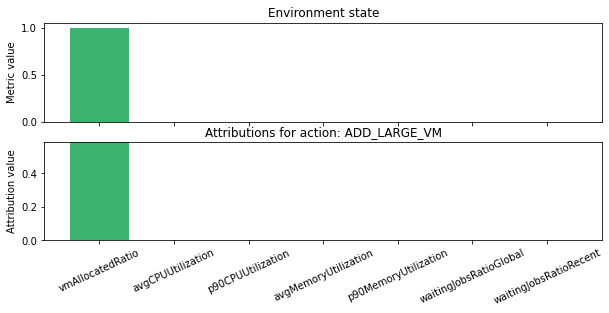

In [28]:
main_ig_attributor.explain_example(idx=1)

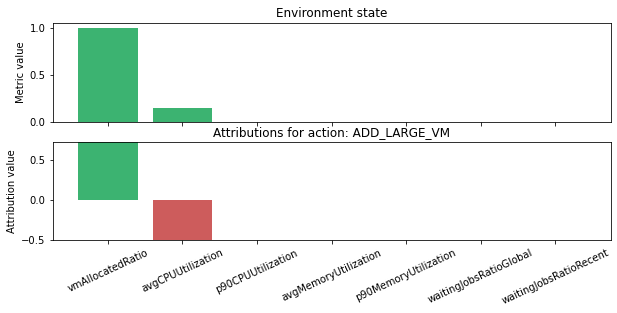

In [34]:
main_ig_attributor.explain_example(idx=10)